# 100 Days of Kaggle challenge: Day 1

Hi, I'm a Machine Learning enthusiast looking forward to provide you with valuable information, from notebooks like this.
In this notebook, we will start with the first step in tackling a DL problem - Getting familiar with data.
For this example, I'll use the wheat dataset, which was supplied by the organisers for [Global Wheat Detection](https://www.kaggle.com/c/global-wheat-detection/overview) Competition. I highly suggest you to go to that link and get a high level overview of what is present inside this dataset. The techniques used in this notebook is inspired from [this](https://www.kaggle.com/reighns/augmentations-data-cleaning-and-bounding-boxes) notebook by [reigHns](https://www.kaggle.com/reighns)
For best learning experience, fork this notebook and follow along

In [ ]:
# Importing the bread and butter for every Deep-Learning problem
import numpy as np
import pandas as pd

# Importing OS for accessing data
import os

# For plotting stuff
import matplotlib.pyplot as plt

# For reading images
import cv2

%matplotlib inline

# Setting the random seed so that y'all don't get different images when you run the notebook yourself
np.random.seed(0)

In [ ]:
# Setting the root directory, so that we don't have to type the same path everytime
root_dir = '/kaggle/input/global-wheat-detection/'

#Let's see what files do we have here
for file in os.listdir(root_dir):
    print(file)

Just in case you didn't check out the [Global Wheat Detection](https://www.kaggle.com/c/global-wheat-detection/overview), we have bounding boxes for 'Wheat heads' inside the 'train.csv' file. The csv file has a row for every bounding box. They have also mentioned that not every image has a bounding box. All in all we can conclude that a single image may have many bounding boxes, whereas some images might not have a bounding box at all. That's good information. Let's look at the csv for now.

In [ ]:
train = pd.read_csv(root_dir+'train.csv')
train.head()

**The fields look self explanatory, but just in case if you're a noob**

Image_id - Name of the image

width, height - how wide and how tall the image is, with respect to pixels

bbox - Contains 4 set of points [starting x co-ordinate, starting_y_co-ordinate, width_of_bb, height_of_bb

source - Not sure but I guess it's some sort of username of the guy/girl who provided this dataset. Kudos for same!


# Sneak peek at the pictures
Let's look at some images because let's be honest we'd rather see images than code. We still gotta type code to see the images tho.


In [ ]:
nncols = 4
train_path = os.path.join(root_dir, 'train') 
image_files_list = os.listdir(train_path)
main_title = "Just some pictures of Wheat"

# Here's a generic function to plot multiple images at once
def plot_random_images(image_files_list, image_path, nrows=3, ncols=4, main_title=""):
    """
    image_files_list : List containing all of the image files, stacked on axis 0
    nrows            : Number of rows of pictures
    ncols            : Number of columns of pictures
    main_title       : Main title for sub-plots
    """
    
    # Selecting a random number of images from the given list
    random_img_list = np.random.choice(image_files_list, nrows * ncols)
    
    # Reading images and appending them to the image_matrix_list
    image_matrix_list = []
    for file in random_img_list:
        img = cv2.imread(os.path.join(image_path, file))
        image_matrix_list.append(img)
        
    # Setting the subplots as per inputs provided
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize = (20, 15), squeeze=False)
    fig.suptitle('Wheat', fontsize=30)
    num=0
    for i in range(nrows):
        for j in range(ncols):
            axes[i][j].imshow(image_matrix_list[num])
            axes[i][j].set_title(random_img_list[num], fontsize=14)
            num += 1
    plt.show()
    
# Finally plotting the images
plot_random_images(image_files_list, train_path, 3, 4, main_title)

# Plotting Images with Bounding Boxes
These images look good, but nobody will take you seriously if you don't show bounding boxes for the wheat heads. Let's work on that!

For quicker plotting of the data, it would be much better if we manipulate the csv itself.
This is how the csv looks right now
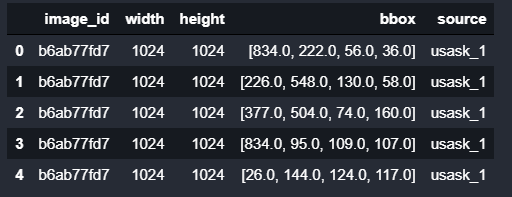

In [ ]:
train.describe()

Damn, this means only these two columns are storing numeric values. But the values look same for every row, so they're kinda  useless right now. Get your surgical gloves on, because we'll need to do some serious operations on this thing.


In [ ]:
"""
For starters, we will restructure the way bounding boxes are stored, so that it's easier for us to plot them on the images
Let's get these bb's

Here, we apply a lambda function to the bbox column, to extract the 4 numbers from the string. Since the first and the last characters
are '[' and ']' respectively, we started the slicing from index 1, and left out the last index, and using "," as seperator

"""
bboxes = np.stack(train['bbox'].apply(lambda x : np.fromstring(x[1:-1], sep = ",")))

# Now we add new columns, namely x_min and y_min to the csv file
for i, column in enumerate(['x_min', 'y_min', 'width', 'height']):
    train[column] = bboxes[:, i]
    
# These lines will add the columns x_max and y_max to the csv file, and fill them with appropriate data
train["x_max"] = train.apply(lambda col: col.x_min+col.width, axis=1)
train["y_max"] = train.apply(lambda col: col.y_min + col.height, axis=1)

# Let's see if how our operation looks like for now
train.head()

Impresssive! We don't need width, height and bbox anymore, so they gotta go.

In [ ]:
train.drop(columns=['bbox', 'width', 'height'], inplace=True)
train.head()

Sweet! CSV looks crisp. We gotta do a small validation to ensure that x_max and y_max do not exceed the value (1024), since the image is of size 1024 * 1024

In [ ]:
x_max = np.array(train["x_max"].values.tolist())
y_max = np.array(train["y_max"].values.tolist())

"""
np.where works like a conditional statement. for eg. if x_max>1024, replace the value with 1024, else retain the original value of xmax. This is ofcourse done for every value in the numpy array.
"""
train["x_max"] = np.where(x_max > 1024, 1024, x_max).tolist()
train["y_max"] = np.where(y_max > 1024, 1024, y_max).tolist()
 

Also, we might as well add '.jpg' at the end of every image id, since that is the actual name of the image. But are all the images .jpgs? 

In [ ]:
extensions = []
for file in os.listdir(os.path.join(root_dir, 'train')):
    extension = file.split(".")[1]
    if extension not in extensions:
        extensions.append(extension)

if len(extensions) == 1:
    print(f"All images are of extension '{extensions[0]}'")
else:
    print(f"Looks like we have a problem. Not all the images have same extensions.")

In [ ]:
# Sweet!, now we can rename the values
train["image_id"] = train['image_id'].apply(lambda x: x + '.jpg')
train.head()

In [ ]:
# Let's save our csv
train.to_csv("wheat.csv", index=False)
wheat = pd.read_csv("wheat.csv")

#Selecting the first image from the csv file. The same image id appears multiple times, because there are multiple bounding boxes inside that image
chosen_image = cv2.imread(os.path.join(train_path, "b6ab77fd7.jpg"))
chosen_image_df = wheat.loc[wheat["image_id"]=="b6ab77fd7.jpg", ["x_min", "y_min", "x_max", "y_max"]]
bbox_array = np.array(chosen_image_df.values.tolist())
bbox_array.shape


Looks like there are 47 bounding boxes in this image. Let's plot them on our image and show everyone that we mean business!

In [ ]:
for i in range(len(bbox_array)):
    # Apparenetly this cv2.rectangle function fails when we pass points which are floats. That's why we gotta convert our rectangle points to integers
    """
    pt 1 contains (x_min, y_min)
    pt 2 contains (x_max, y_max)
    """
    pt1 = (int(bbox_array[i][0]), int(bbox_array[i][1]))
    pt2 = (int(bbox_array[i][2]), int(bbox_array[i][3]))
    draw_chosen_image = cv2.rectangle(chosen_image, pt1, pt2, (0, 255, 0), 5)
plt.imshow(draw_chosen_image)

In [ ]:
"""
Cool. Let's scale it for multiple images. We will use the generic function we defined above (plot_random_images()). 
We will draw the rectangles on images, and then pass the image matrix
"""

images_list = os.listdir(train_path)

def draw_images_with_bboxes(images_list, image_annotation_file, nrows, ncols, main_title=""):
    image_matrix = []
    random_list = np.random.choice(images_list, 12)
    for image in random_list:
        img = cv2.imread(os.path.join(train_path, image))
        img_df = image_annotation_file.loc[image_annotation_file['image_id'] == image, ["x_min", "y_min", "x_max", "y_max"]]
        bboxes = np.array(img_df.values.tolist())

        for i,bbox in enumerate(bboxes):
            pt1 = (int(bbox[0]), int(bbox[1]))
            pt2 = (int(bbox[2]), int(bbox[3]))
            img = cv2.rectangle(img, pt1, pt2, (255, 0, 0), 5)

        image_matrix.append(img)
    fig, axes = plt.subplots(nrows, ncols, figsize=(20, 15))
    fig.suptitle(main_title, fontsize=30)
    num = 0
    for i in range(nrows):
        for j in range(ncols):
            axes[i][j].imshow(image_matrix[num])
            axes[i][j].set_title(random_list[num], fontsize=14)
            num += 1
            
draw_images_with_bboxes(images_list, wheat, 3, 4, "Wheat heads with Bounding boxes")

# Conclusion
Now we know how our csv needs to be for plotting the bounding boxes on images. We also saw how to plot bb's on images. We have two generic functions to plot a random sample of our dataset, and another one to plot random images from the same dataset, but with bb's. That's all for day one, I can't wait to start with day 2!